In [1]:
# Cell 1: Import required libraries
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Input, Dense, GlobalMaxPooling2D, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt
import csv
from datetime import datetime
from sklearn.model_selection import train_test_split
import shutil

print("TensorFlow version:", tf.__version__)

E0000 00:00:1730964223.383254      13 common_lib.cc:798] Could not set metric server port: INVALID_ARGUMENT: Could not find SliceBuilder port 8471 in any of the 0 ports provided in `tpu_process_addresses`="local"
=== Source Location Trace: === 
learning/45eac/tfrc/runtime/common_lib.cc:479
D1107 07:23:43.391496479      13 config.cc:196]                        gRPC EXPERIMENT call_status_override_on_cancellation   OFF (default:OFF)
D1107 07:23:43.391511003      13 config.cc:196]                        gRPC EXPERIMENT call_v3                                OFF (default:OFF)
D1107 07:23:43.391514333      13 config.cc:196]                        gRPC EXPERIMENT canary_client_privacy                  ON  (default:ON)
D1107 07:23:43.391516844      13 config.cc:196]                        gRPC EXPERIMENT capture_base_context                   ON  (default:ON)
D1107 07:23:43.391519330      13 config.cc:196]                        gRPC EXPERIMENT client_idleness                        ON  (defa

TensorFlow version: 2.16.1


In [2]:
# Cell 2: Initialize TPU and set up strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU:', tpu.master())
except ValueError:
    tpu = None
    print('Not connected to a TPU runtime')

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()
print("REPLICAS:", strategy.num_replicas_in_sync)


Running on TPU: 
INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.
INFO:tensorflow:Initializing the TPU system: local


I0000 00:00:1730964238.219973      13 service.cc:145] XLA service 0x5cde9de2df40 initialized for platform TPU (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1730964238.220024      13 service.cc:153]   StreamExecutor device (0): TPU, 2a886c8
I0000 00:00:1730964238.220028      13 service.cc:153]   StreamExecutor device (1): TPU, 2a886c8
I0000 00:00:1730964238.220031      13 service.cc:153]   StreamExecutor device (2): TPU, 2a886c8
I0000 00:00:1730964238.220034      13 service.cc:153]   StreamExecutor device (3): TPU, 2a886c8
I0000 00:00:1730964238.220037      13 service.cc:153]   StreamExecutor device (4): TPU, 2a886c8
I0000 00:00:1730964238.220039      13 service.cc:153]   StreamExecutor device (5): TPU, 2a886c8
I0000 00:00:1730964238.220042      13 service.cc:153]   StreamExecutor device (6): TPU, 2a886c8
I0000 00:00:1730964238.220044      13 service.cc:153]   StreamExecutor device (7): TPU, 2a886c8


INFO:tensorflow:Finished initializing TPU system.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)
I

In [3]:
# Cell 3: Download and extract dataset
!pip install gdown
!gdown --id 17_KUaj9z0NSAODwE368_irCrnSOajSg- -O /kaggle/working/final_dataset2.zip

# Define the path to the zip file
zip_file_path = '/kaggle/working/final_dataset2.zip'
# Define the extraction path
extracted_data_path = '/kaggle/working'
# Unzip the file
!unzip -q {zip_file_path} -d {extracted_data_path}
# List the files to verify
!ls {extracted_data_path}


[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
/usr/local/lib/python3.10/site-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=17_KUaj9z0NSAODwE368_irCrnSOajSg-
From (redirected): https://drive.google.com/uc?id=17_KUaj9z0NSAODwE368_irCrnSOajSg-&confirm=t&uuid=27818c6e-4fd2-4cdc-8131-a888d1af218d
To: /kaggle/working/final_dataset2.zip
100%|█████████████████████████████████████████| 757M/757M [00:03<00:00, 199MB/s]
final_dataset  final_dataset2.zip


In [4]:
# Cell 4: Define dataset paths and split data into training and testing
DATASET_BASE_PATH = '/kaggle/working/final_dataset'
TRAIN_PATH = '/kaggle/working/train'
TEST_PATH = '/kaggle/working/test'

# Create directories for train and test split
os.makedirs(TRAIN_PATH, exist_ok=True)
os.makedirs(TEST_PATH, exist_ok=True)

for class_name in ['hc', 'pd', 'prodromal']:
    class_path = os.path.join(DATASET_BASE_PATH, class_name)
    train_class_path = os.path.join(TRAIN_PATH, class_name)
    test_class_path = os.path.join(TEST_PATH, class_name)
    os.makedirs(train_class_path, exist_ok=True)
    os.makedirs(test_class_path, exist_ok=True)
    
    # List all images in the class directory
    all_images = os.listdir(class_path)
    train_images, test_images = train_test_split(all_images, test_size=0.2, random_state=42)
    
    # Move images to the corresponding train and test directories
    for img in train_images:
        shutil.copy(os.path.join(class_path, img), os.path.join(train_class_path, img))
    for img in test_images:
        shutil.copy(os.path.join(class_path, img), os.path.join(test_class_path, img))

print(f"Data split into training and testing sets at {TRAIN_PATH} and {TEST_PATH}")

Data split into training and testing sets at /kaggle/working/train and /kaggle/working/test


In [5]:
# Cell 5: Load data using tf.data.Dataset
def load_data():
    BATCH_SIZE = 32 * strategy.num_replicas_in_sync  # Adjust as needed
    IMG_SIZE = (224, 224)

    train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
        TRAIN_PATH,
        labels='inferred',
        label_mode='categorical',
        batch_size=BATCH_SIZE,
        image_size=IMG_SIZE,
        shuffle=True
    )

    test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
        TEST_PATH,
        labels='inferred',
        label_mode='categorical',
        batch_size=BATCH_SIZE,
        image_size=IMG_SIZE,
        shuffle=False
    )

    return train_dataset, test_dataset

In [6]:
# Cell 6: Load data and output number of images in each set
train_dataset, test_dataset = load_data()

# Get class names and number of classes
class_names = train_dataset.class_names if hasattr(train_dataset, 'class_names') else ['hc', 'pd', 'prodromal']
num_classes = len(class_names)
print(f"Class names: {class_names}")
print(f"Number of classes: {num_classes}")

# Output number of images in each dataset
train_image_count = sum([len(files) for r, d, files in os.walk(TRAIN_PATH)])
test_image_count = sum([len(files) for r, d, files in os.walk(TEST_PATH)])

print(f"Number of training images: {train_image_count}")
print(f"Number of test images: {test_image_count}")



Found 46021 files belonging to 3 classes.
Found 11506 files belonging to 3 classes.
Class names: ['hc', 'pd', 'prodromal']
Number of classes: 3
Number of training images: 46022
Number of test images: 11506


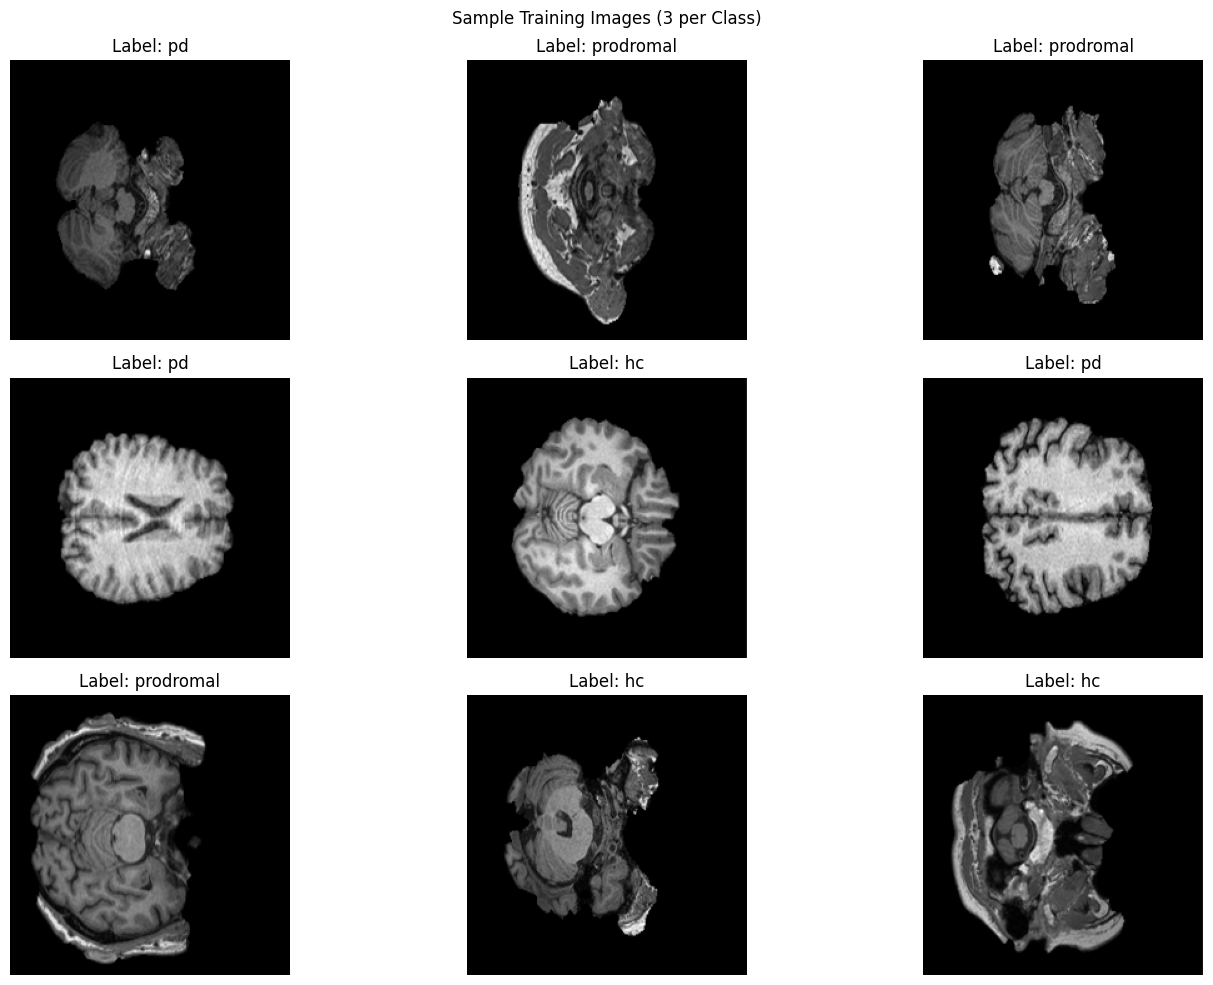

In [7]:
# Cell 7: Data verification - Display 9 images

# Ensure train_dataset is defined by loading the data
if 'train_dataset' not in globals() or 'class_names' not in globals():
    train_dataset, test_dataset = load_data()
    class_names = train_dataset.class_names

def display_sample_images(dataset, class_names):
    plt.figure(figsize=(15, 10))
    for images, labels in dataset.take(1):
        num_classes = len(class_names)
        class_counts = {i: 0 for i in range(num_classes)}
        images_displayed = 0
        for idx in range(len(images)):
            class_idx = tf.argmax(labels[idx]).numpy()
            if class_counts[class_idx] < 3:
                plt.subplot(3, 3, images_displayed + 1)
                plt.imshow(images[idx].numpy().astype("uint8"))
                plt.title(f"Label: {class_names[class_idx]}")
                plt.axis('off')
                class_counts[class_idx] += 1
                images_displayed += 1
            if images_displayed == 9:
                break
    plt.suptitle('Sample Training Images (3 per Class)')
    plt.tight_layout()
    plt.show()

display_sample_images(train_dataset, class_names)

In [8]:
# Cell 8: Build the Model with a New Layer Structure

# Regularization factor
from tensorflow.keras.regularizers import l2
regularization = l2(0.0001)

# Ensure num_classes is defined
if 'num_classes' not in globals():
    num_classes = len(train_dataset.class_names)

with strategy.scope():
    # Load the base model with ImageNet weights, excluding the top layer
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False  # Freeze the base model

    # Add Global Average Pooling layer
    x = base_model.output
    x = GlobalAveragePooling2D()(x)

    # Dense layer structure
    x = Dense(1024, activation='relu', kernel_regularizer=regularization)(x)
    x = Dropout(0.5)(x)
    x = Dense(512, activation='relu', kernel_regularizer=regularization)(x)
    x = Dropout(0.3)(x)
    x = Dense(256, activation='relu', kernel_regularizer=regularization)(x)
    x = Dropout(0.2)(x)
    x = Dense(128, activation='relu', kernel_regularizer=regularization)(x)
    x = Dropout(0.1)(x)
    x = Dense(64, activation='relu', kernel_regularizer=regularization)(x)
    x = Dropout(0.05)(x)
    x = Dense(32, activation='relu', kernel_regularizer=regularization)(x)
    x = Dropout(0.025)(x)

    # Output layer for classification
    output_layer = Dense(num_classes, activation='softmax')(x)

    # Create the complete model
    model = Model(inputs=base_model.input, outputs=output_layer)

    # Compile the model with Adam optimizer
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss='categorical_crossentropy',
        metrics=[
            'accuracy',                   # Track accuracy
            tf.keras.metrics.Precision(),  # Precision metric
            tf.keras.metrics.Recall(),     # Recall metric
            tf.keras.metrics.AUC(name='auc')  # AUC metric for overall performance
        ]
    )

    # Display the model summary
    model.summary()


I0000 00:00:1730964277.408119      13 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 26,385,347 (100.65 MB)

 Trainable params: 2,797,635 (10.67 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [9]:
# Cell 9: Training the model
EPOCHS = 100  # Define the number of epochs

# Define callbacks (optional)
callbacks = [
    ReduceLROnPlateau(monitor='loss', factor=0.1, patience=5, verbose=1)
]

# Wrap training and saving within the TPU strategy scope
with strategy.scope():
    history = model.fit(
        train_dataset,
        epochs=EPOCHS,
        verbose=2,  # Display progress with a progress bar
        callbacks=callbacks
    )

    # Save the model with a timestamp
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    model_save_path_with_timestamp = os.path.join(DATASET_BASE_PATH, f"resnet50_model_{timestamp}.h5")

    # Save the model without wrapping in tf.device
    model.save(model_save_path_with_timestamp)
    print(f"Model saved to: {model_save_path_with_timestamp}")

Epoch 1/100


2024-11-07 07:25:03.244332: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node StatefulPartitionedCall.
I0000 00:00:1730964304.513554     825 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(aea7c0834a5c708a:0:0), session_name()
I0000 00:00:1730964318.450737     825 tpu_compile_op_common.cc:245] Compilation of aea7c0834a5c708a:0:0 with session name  took 13.937121183s and succeeded
I0000 00:00:1730964318.492961     825 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(aea7c0834a5c708a:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_13963658902572508934", property.function_library_fingerprint = 9641727269327643920, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z 

180/180 - 50s - 277ms/step - accuracy: 0.3949 - auc: 0.5846 - loss: 1.3351 - precision: 0.5069 - recall: 0.0318 - learning_rate: 1.0000e-04


I0000 00:00:1730964347.649176     794 tpu_compile_op_common.cc:245] Compilation of 9655de63ad837c0f:0:0 with session name  took 12.627908837s and succeeded
I0000 00:00:1730964347.703008     794 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(9655de63ad837c0f:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_iterator_13963658902572508934", property.function_library_fingerprint = 9641727269327643920, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "25,224,224,3,;25,3,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1730964347.703053     794 tpu_compilation_cache_interface.cc:541] After adding entry for ke

Epoch 2/100
180/180 - 18s - 101ms/step - accuracy: 0.4985 - auc: 0.6958 - loss: 1.2285 - precision: 0.5621 - recall: 0.2187 - learning_rate: 1.0000e-04
Epoch 3/100
180/180 - 18s - 99ms/step - accuracy: 0.5435 - auc: 0.7401 - loss: 1.1602 - precision: 0.5971 - recall: 0.3534 - learning_rate: 1.0000e-04
Epoch 4/100
180/180 - 18s - 98ms/step - accuracy: 0.5682 - auc: 0.7656 - loss: 1.1122 - precision: 0.6254 - recall: 0.4227 - learning_rate: 1.0000e-04
Epoch 5/100
180/180 - 17s - 97ms/step - accuracy: 0.6065 - auc: 0.7989 - loss: 1.0489 - precision: 0.6548 - recall: 0.4872 - learning_rate: 1.0000e-04
Epoch 6/100
180/180 - 18s - 102ms/step - accuracy: 0.6169 - auc: 0.8122 - loss: 1.0171 - precision: 0.6600 - recall: 0.5183 - learning_rate: 1.0000e-04
Epoch 7/100
180/180 - 18s - 101ms/step - accuracy: 0.6570 - auc: 0.8397 - loss: 0.9597 - precision: 0.7002 - recall: 0.5773 - learning_rate: 1.0000e-04
Epoch 8/100
180/180 - 18s - 101ms/step - accuracy: 0.6685 - auc: 0.8533 - loss: 0.9249 - pr

Model saved to: /kaggle/working/final_dataset/resnet50_model_20241107_075426.h5


Training history plot saved to: /kaggle/working/training_history.png


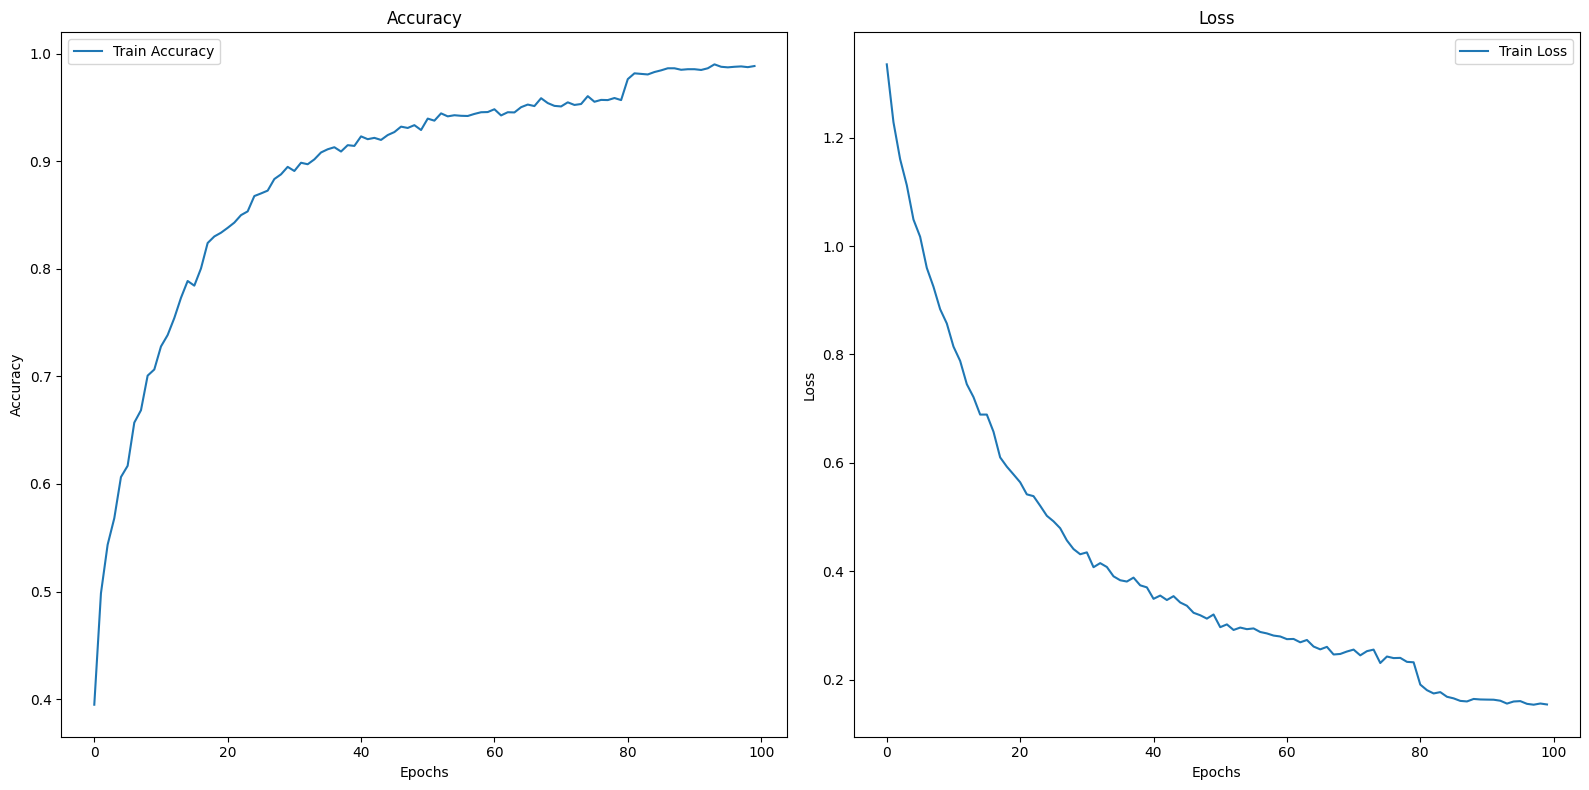

In [10]:
# Cell 10: Plot training history
def plot_training_history(history):
    plt.figure(figsize=(16, 8))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss')

    # Save the figure as a PNG in the working directory
    plot_save_path = os.path.join(extracted_data_path, 'training_history.png')
    plt.tight_layout()
    plt.savefig(plot_save_path, format='png')  # Explicitly save as PNG
    print(f'Training history plot saved to: {plot_save_path}')

plot_training_history(history)


In [11]:
# Cell 11: Generate predictions and classification report, ROC curve, and other metrics
# Define function to evaluate the model
def evaluate_model_on_test_data(model, test_dataset, class_names):
    # Generate predictions on the test dataset
    y_pred_prob = model.predict(test_dataset)
    y_pred = np.argmax(y_pred_prob, axis=1)

    # Extract true labels from the dataset
    y_true = []
    for images, labels in test_dataset:
        y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_true = np.array(y_true)

    # Create a directory to save the plots if it doesn't exist
    plot_save_dir = "plots/"
    if not os.path.exists(plot_save_dir):
        os.makedirs(plot_save_dir)
    
    # Confusion Matrix
    conf_matrix = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix - Test Set')
    
    # Save confusion matrix plot
    confusion_matrix_plot_path = os.path.join(plot_save_dir, 'confusion_matrix.png')
    plt.savefig(confusion_matrix_plot_path)
    print(f"Confusion matrix plot saved to: {confusion_matrix_plot_path}")
    plt.close()  # Close the figure to free up memory

    # Classification Report
    report = classification_report(y_true, y_pred, target_names=class_names)
    print(f"Classification Report:\n{report}")
    
    # Save classification report to a text file
    classification_report_path = os.path.join(plot_save_dir, 'classification_report.txt')
    with open(classification_report_path, 'w') as f:
        f.write(report)
    print(f"Classification report saved to: {classification_report_path}")

    # F1, Precision, Recall, Accuracy
    f1 = f1_score(y_true, y_pred, average='weighted')
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    accuracy = accuracy_score(y_true, y_pred)

    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Test F1 Score (Weighted): {f1:.4f}")
    print(f"Test Precision (Weighted): {precision:.4f}")
    print(f"Test Recall (Weighted): {recall:.4f}")

    # Save these metrics to a text file
    metrics_report_path = os.path.join(plot_save_dir, 'metrics_report.txt')
    with open(metrics_report_path, 'w') as f:
        f.write(f"Test Accuracy: {accuracy:.4f}\n")
        f.write(f"Test F1 Score (Weighted): {f1:.4f}\n")
        f.write(f"Test Precision (Weighted): {precision:.4f}\n")
        f.write(f"Test Recall (Weighted): {recall:.4f}\n")
    print(f"Metrics report saved to: {metrics_report_path}")

    # ROC Curve and AUC Score for each class
    plt.figure(figsize=(10, 8))
    for i, class_name in enumerate(class_names):
        fpr, tpr, _ = roc_curve(y_true == i, y_pred_prob[:, i])
        auc_score = roc_auc_score(y_true == i, y_pred_prob[:, i])
        plt.plot(fpr, tpr, label=f'{class_name} (AUC = {auc_score:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve - Test Set')
    plt.legend(loc='lower right')

    # Save ROC curve plot
    roc_plot_path = os.path.join(plot_save_dir, 'roc_curve.png')
    plt.savefig(roc_plot_path)
    print(f"ROC curve plot saved to: {roc_plot_path}")
    plt.close()  # Close the figure to free up memory

    # Additional metrics or plots can be added here and saved similarly

# Call the evaluation function
evaluate_model_on_test_data(model, test_dataset, class_names)


2024-11-07 07:54:31.384834: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node functional_1/conv1_bn_1/Cast/ReadVariableOp.
I0000 00:00:1730966071.793483     808 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(9411c709b4f25d7d:0:0), session_name()


 1/45 ━━━━━━━━━━━━━━━━━━━━ 5:47 8s/step

I0000 00:00:1730966076.215536     808 tpu_compile_op_common.cc:245] Compilation of 9411c709b4f25d7d:0:0 with session name  took 4.422003881s and succeeded
I0000 00:00:1730966076.228801     808 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(9411c709b4f25d7d:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_distributed_13398837362999408107", property.function_library_fingerprint = 3797226503156891904, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1730966076.228828     808 tpu_compilation_cache_interface.cc:541] After adding entry for key 9411c709b4f

44/45 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step

I0000 00:00:1730966089.905896     763 tpu_compilation_cache_interface.cc:441] TPU host compilation cache miss: cache_key(d1b7a8d8403a201b:0:0), session_name()


45/45 ━━━━━━━━━━━━━━━━━━━━ 26s 409ms/step


I0000 00:00:1730966094.194483     763 tpu_compile_op_common.cc:245] Compilation of d1b7a8d8403a201b:0:0 with session name  took 4.288549423s and succeeded
I0000 00:00:1730966094.205758     763 tpu_compilation_cache_interface.cc:475] TPU host compilation cache: compilation complete for cache_key(d1b7a8d8403a201b:0:0), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_distributed_15808909476351135965", property.function_library_fingerprint = 8349248125138775198, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, std::string(property.shapes_prefix) = "31,224,224,3,;31,3,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
I0000 00:00:1730966094.205790     763 tpu_compilation_cache_interface.cc:541] After adding entry

Confusion matrix plot saved to: plots/confusion_matrix.png
Classification Report:
              precision    recall  f1-score   support

          hc       0.96      0.96      0.96      3707
          pd       0.95      0.95      0.95      3810
   prodromal       0.96      0.95      0.95      3989

    accuracy                           0.95     11506
   macro avg       0.95      0.95      0.95     11506
weighted avg       0.95      0.95      0.95     11506

Classification report saved to: plots/classification_report.txt
Test Accuracy: 0.9536
Test F1 Score (Weighted): 0.9536
Test Precision (Weighted): 0.9536
Test Recall (Weighted): 0.9536
Metrics report saved to: plots/metrics_report.txt
ROC curve plot saved to: plots/roc_curve.png


In [12]:
import os
import pandas as pd

# Define the base paths
train_path = "/kaggle/working/train"
test_path = "/kaggle/working/test"

# Function to gather image names and labels
def get_image_labels(base_path):
    data = []
    # Loop through each class folder in the base path
    for class_name in os.listdir(base_path):
        class_folder = os.path.join(base_path, class_name)
        # Ensure it's a directory before proceeding
        if os.path.isdir(class_folder):
            # Loop through each image in the class folder
            for img_name in os.listdir(class_folder):
                # Append the image path and class name
                data.append((img_name, class_name))
    return data

# Get data for train and test sets
train_data = get_image_labels(train_path)
test_data = get_image_labels(test_path)

# Convert to DataFrames for better readability or further processing
train_df = pd.DataFrame(train_data, columns=["Image_Name", "Class"])
test_df = pd.DataFrame(test_data, columns=["Image_Name", "Class"])

# Display sample of train and test DataFrames
print("Train Data Sample:")
print(train_df.head())
print("\nTest Data Sample:")
print(test_df.head())

# If you want to save these as CSV files for reference
train_df.to_csv("/kaggle/working/train_image_labels.csv", index=False)
test_df.to_csv("/kaggle/working/test_image_labels.csv", index=False)


Train Data Sample:
       Image_Name Class
0  image_6763.jpg    pd
1  image_8579.jpg    pd
2  image_7376.jpg    pd
3   image_636.jpg    pd
4  image_2521.jpg    pd

Test Data Sample:
        Image_Name Class
0   image_5455.jpg    pd
1   image_3512.jpg    pd
2  image_17792.jpg    pd
3   image_2441.jpg    pd
4   image_7971.jpg    pd
